## Linear Regression - Stochastic Gradient Descent Linear Regression & OLS Polynomial Regression


There are four tasks for this recitation:
- Perform Linear Regression using sklearn's SGDRegressor
- Perform Polynomial Regression using sklearn's OLS method
- Plot degree vs. error to choose optimal degree for a fixed set datasize
- Plot learning curves to investigate how the size of training data influeces the model performance for various polynomial models

You will use the **Red wine** quality dataset from the following link.

### Dataset

URL: https://archive.ics.uci.edu/ml/datasets/wine+quality

The dataset is related to the **Red** variants of the Portuguese "Vinho Verde" wine. It provides the physicochemical (inputs) and sensory (the output) variables are available.

The dataset consists of characteristics of white wine (e.g., alcohol content, density, amount of citric acid, pH, etc) with target variable "quality" representing rating of wine.


Given the characteristics of a new, unlabeled wine, the regression task is to predict its "quality".

Input variables (based on physicochemical tests):
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data): 
- quality 


In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Load Data

First load the data and explore the feature names, target names, etc.

In [2]:
# Load data
df = pd.read_csv('./datasets/winequality-red.csv', sep=';')

# Exploratory Data Analysis

Perform EDA and determine the following:
- Are the input variables collinear?
- Do you need to drop any input variable column? 

Drop the redundant columns if need be. However, if dropping a column doesn't achieve the best accuracy, then don't drop it.

In [3]:
df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


# Create a Separate Feature Set (Data Matrix X) and Target (1D Vector y)

Create a data matrix (X) that contains all features and a 1D target vector (y) containing the target.



In [4]:
allData = df
X = df.drop(columns='quality')
y = df['quality']

print(X.shape)
print(y.shape)

(1599, 11)
(1599,)


# Scale The Features

We should ensure that all features have a similar scale. Otherwise optimization algorithms (e.g., Gradient Descent based algorithms) will take much longer time to converge.

Also, regularization techniques are sensitive to the scale of data. Thus, you must scale the features before applying regularization.

In [5]:
scalar = StandardScaler().fit(X)
X = scalar.transform(X)

# Create Train and Test Dataset

Use the **"random_state"** attribute of the "train_test_split" function to ensure the reproducability of your results.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Implementation of Sklearn's Stochastic Gradient Descent (SGD)


Perform linear regression by using sklearn's SGDRegressor. You should use **regularized** SGDRegressor.

First, you will select the best model via hyperparameter tuning. Use sklearn's GridSearchCV.

Find the best combination of the following hyperparameters. You may add other parameters in this list if you find it reasonable.

- alpha
- learning_rate ("constant", "optimal")
- eta0
- l1_ratio
- max_iter
- eta0

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For regression, you may use "neg_mean_squared_error" or "explained_variance" scoring function. 



## Hyperparameter Tuning for SGD Regressor

You should tune the following hyper-parameters. Below I have suggested some values and range, but you are free to explore. Please note that the tuning will take longer time. So, have patience!

- alpha: 0.1, 0.01, 0.001
- learning_rate: "constant", "optimal"
- l1_ratio': from 0 to 1
- max_iter': try larger iterations from 10000
- eta0: 0.01, 0.001

#### Report the best score (negative mean squared error) & optimal hyperparameter values.

In [7]:
param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
              'l1_ratio': [1, 0.75, 0.25, 0], 'max_iter':[10000, 15000, 30000],'eta0': [0.01, 0.001]}

sgd = SGDRegressor()

sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=10)
sgd_cv.fit(X_train, y_train)

print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/skl

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Best Score (negative mean squared error): -0.434035
Optimal Hyperparameter Values:  {'alpha': 0.001, 'eta0': 0.001, 'l1_ratio': 0.75, 'learning_rate': 'constant', 'max_iter': 10000}


## Select The Best Model for the SGD Regressor

Using the optimal hyperparameter values, create the best model.
Then, fit the model.


Report the following two evaluation metrics.

- Mean Squared Error (MSE)
- Coefficient of Determination or $R^2$/$r^2$


In [8]:
# SGD Regression using the best model
lin_reg_sgd = SGDRegressor(max_iter=10000, learning_rate="constant", eta0=0.001, penalty="elasticnet", l1_ratio=0.75, alpha=0.001)


# Train the model
lin_reg_sgd.fit(X_train, y_train)

# The intercept
print("Intercept: \n", lin_reg_sgd.intercept_)

# The coefficients
print("Coefficients: \n", lin_reg_sgd.coef_)

# The number of iterations
print("Number of Iterations: \n", lin_reg_sgd.n_iter_)

# Make prediction on the training data
y_train_predicted_sgd = lin_reg_sgd.predict(X_train)

print("Mean squared error: %.2f" % mean_squared_error(y_train, y_train_predicted_sgd))

print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_predicted_sgd))

/Users/mbennett/PycharmProjects/bennett_matthew_1/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Intercept: 
 [5.62543186]
Coefficients: 
 [ 0.03680293 -0.17876719 -0.02092806  0.003194   -0.08640952  0.05188539
 -0.12448101 -0.01298856 -0.06025771  0.14131495  0.3029198 ]
Number of Iterations: 
 10000
Mean squared error: 0.42
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.35


## Evaluate Model Performance Using Test Data

In [9]:
# Make prediction using the test data
y_test_predicted = lin_reg_sgd.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_predicted))

print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_test, y_test_predicted))

Mean squared error: 0.39
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.40


# <font color=blue>Polynomial Regression Using the OLS Method</font>



## Choose the Optimal Degree (Model Complexity) of the Polynomial Regression

Vary the degree of the polynomial (degree 1, 2 & 3) and train the sklearn's Linear Regression model (OLS) using the training data. Then, compute the mean squared error (mse) for the test data using the models with varying degree.

Finally, plot the **root mean square error (rmse)** values against the varying degree. From this plot find the optimal degree (that gives the smallest rmse).


## <font color=red> Note for Assignment 3:

For the assignment you will have to use cross-validation to get an estimate of a model’s generalization performance. 

You will write a function to plot the training and validation root mean square error (rmse) values of the data matrix X for various polynomial degree starting from 1 up to the value set by max polynomial degree. It takes the data matrix X (usually the training data matrix) and the max polynomial degree; and for each polynomial degree it will augment the data matrix, then use k-fold cross-validation to compute the average mse for both the training and the validation fold. For training the model (using the “fit” method) it will use the model parameters from the function argument. Finally, the function will plot the root-mean-square error (rmse) values for the training and validation folds for each degree of the data matrix starting from 1 up to the max polynomial degree.


## Model's Complexity: Overfitting or Underfitting
If a model performs well on the training data but generalizes poorly (on the validation data) according to the cross-validation metrics, then your model is overfitting. If it performs poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

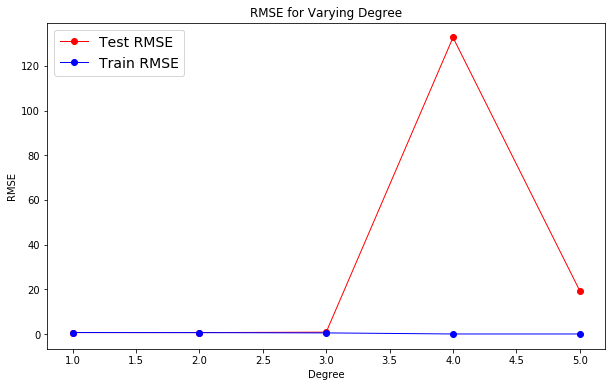

In [10]:
# RMSE vs. Degree Curve
degreeList = [1,2,3,4,5]

mse_train, mse_test = [], []

for degree in degreeList:

    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
  
    model.fit(X_train, y_train)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train)
    y_test_predicted = model.predict(X_test)
    
    
    mse_train.append(mean_squared_error(y_train, y_train_predicted))
    mse_test.append(mean_squared_error(y_test, y_test_predicted))
   

plt.figure(figsize=(10, 6))   
plt.plot(degreeList, np.sqrt(mse_test), "ro-", alpha=1.0, linewidth=1.0, label="Test RMSE")
plt.plot(degreeList, np.sqrt(mse_train), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")    
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()



## Determine Model Complexity using Learning Curve

Determine your polynomial regression model's complexity (whether it's overfitting or underfitting) by creating learning curves by varying the degree of polynomial. 

Use skleatn's function for plotting the learning curves.


You will generate two set of learning curves.
- Linear Model
- 4th Degree Polynomial Model

Your goal is to investigate whether your two models are overfitting or underfitting. Under the "Observation" block clearly state your conclusion and justification.

## Learning Curve: Linear Model

In [11]:
# Learning Curve: Linear Model
poly_degree = 2

poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

print(X_train_poly.shape)


lin_reg_poly = LinearRegression()

lin_reg_poly.fit(X_train_poly, y_train)

print("\n----------------------------- Model Evaluation -----------------------------")

y_train_poly_predicted = lin_reg_poly.predict(X_train_poly)

print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_poly_predicted))

print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_poly_predicted))



(1279, 77)

----------------------------- Model Evaluation -----------------------------

Mean squared error: 0.37
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.43


## Observation: Linear Model Learning Curve

#### Conclusion: 
I think this model is underfitting.

#### Justification:
This is because the mean squared error is nearly half and that the prediction is below half.

## Learning Curve: Polynomial Model (4th degree)

In [12]:
# Learning Curve: Polynomial (4th Degree) Model
poly_degree = 4

poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

print(X_train_poly.shape)


lin_reg_poly = LinearRegression()

lin_reg_poly.fit(X_train_poly, y_train)

print("\n----------------------------- Model Evaluation -----------------------------")

y_train_poly_predicted = lin_reg_poly.predict(X_train_poly)

print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_poly_predicted))

print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_poly_predicted))





(1279, 1364)

----------------------------- Model Evaluation -----------------------------

Mean squared error: 0.00
Coefficient of determination r^2 variance score [1 is perfect prediction]: 1.00


## Observation: Polynomial Model (4th degree) Learning Curve

##### Conclusion:
It worked correctly.

##### Justification:
It didn't seem to be overfitted or underfitted and guessed correctly.